In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)

In [2]:
x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_12/xlabels.txt',delim_whitespace=True,header=None)


X_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_12/X.txt',index_col=None,delim_whitespace=True,header=None)
X_all.columns=x_labels.values.squeeze().tolist()
print(X_all)

      $a_{v}$  $b_{f,v}$  $b_{fs,v}$  $b{t,v}$  $a_{a}$  $b_{f,a}$  \
0    4.740280   14.71480     7.94629   3.59968  1.11789    3.55168   
1    4.857980   16.84220     2.44477   6.50020  5.37104   17.50990   
2    5.420790   20.70750     9.65534   6.21518  3.67459   24.99810   
3    1.337280   11.57860     7.62628   8.14195  1.26532   25.55680   
4    5.134520    9.95438     7.57115  10.66760  2.96196    2.12530   
..        ...        ...         ...       ...      ...        ...   
995  1.316780   30.08380    10.33150   7.19801  6.35548    2.29146   
996  2.293370   11.61130    15.41860   3.08812  4.40119   24.90360   
997  3.590750   13.81900     2.51893   7.41213  5.69279   27.71850   
998  3.135200    8.59333    13.61100   3.18266  5.26776   23.08810   
999  0.914937   27.49800     6.74556   2.24665  2.69455   10.98910   

     $b_{fs,a}$  $b_{t,a}$  $k_{peri}$  
0      13.84320    3.68519    0.001700  
1       3.95734    2.10356    0.003966  
2       5.83999    3.75123    0.0005

In [3]:
mask = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_12/output_mask.txt',index_col=None,delim_whitespace=True,header=None)

In [4]:
mask

,0
0,1
1,1
2,1
3,1
4,1
...,...
175,1
176,1
177,1
178,1


In [5]:
np.sum(mask)

0    179
dtype: int64

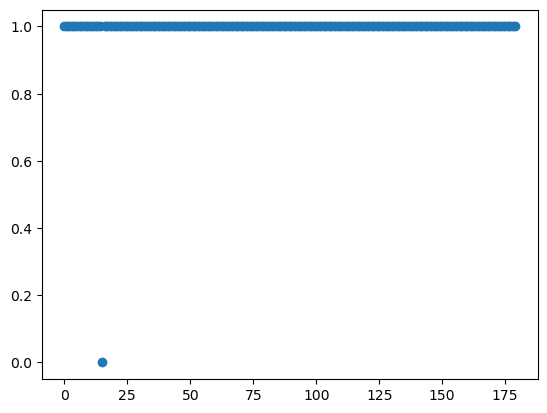

In [6]:
plt.plot(mask,'o')

In [7]:
y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_12/ylabels.txt',delim_whitespace=True,header=None)


y_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_12/Y.txt',index_col=None,delim_whitespace=True,header=None)
y_all.columns=y_labels.values.squeeze().tolist()
print(y_all)

     $V^{\mathrm{max}}_{\mathrm{LV}}$  $V^{\mathrm{max}}_{\mathrm{RV}}$  \
0                             176.068                           171.084   
1                             170.459                           165.900   
2                             170.071                           169.104   
3                             201.667                           191.819   
4                             169.384                           167.307   
..                                ...                               ...   
175                           176.629                           171.773   
176                           186.282                           176.219   
177                           171.946                           168.570   
178                           200.781                           197.025   
179                           165.372                           163.010   

     $V^{\mathrm{max}}_{\mathrm{LA}}$  $V^{\mathrm{max}}_{\mathrm{RA}}$  \
0                       

# Emulator

In [8]:
input_masked = X_all.copy().iloc[0:mask.shape[0]]

In [9]:
y_all[np.array(mask==0)]

,$V^{\mathrm{max}}_{\mathrm{LV}}$,$V^{\mathrm{max}}_{\mathrm{RV}}$,$V^{\mathrm{max}}_{\mathrm{LA}}$,$V^{\mathrm{max}}_{\mathrm{RA}}$,"$\overline{E_{ff,\mathrm{LV}}}$","$\overline{E_{ff,\mathrm{RV}}}$","$\overline{E_{ff,\mathrm{LA}}}$","$\overline{E_{ff,\mathrm{RA}}}$","$\overline{E_{ff,\mathrm{V}}}$","$\overline{E_{ff,\mathrm{A}}}$"
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
input_masked=input_masked.iloc[np.array(mask==1),]
y_all=y_all[np.array(mask==1)]
input_masked.index = y_all.index

In [11]:
input_masked.shape

(179, 9)

In [12]:
y_all.shape

(179, 10)

In [13]:
y_all.index[0]

0

In [14]:
y_all

,$V^{\mathrm{max}}_{\mathrm{LV}}$,$V^{\mathrm{max}}_{\mathrm{RV}}$,$V^{\mathrm{max}}_{\mathrm{LA}}$,$V^{\mathrm{max}}_{\mathrm{RA}}$,"$\overline{E_{ff,\mathrm{LV}}}$","$\overline{E_{ff,\mathrm{RV}}}$","$\overline{E_{ff,\mathrm{LA}}}$","$\overline{E_{ff,\mathrm{RA}}}$","$\overline{E_{ff,\mathrm{V}}}$","$\overline{E_{ff,\mathrm{A}}}$"
0,176.068,171.084,68.2983,87.2082,0.023290,0.018751,0.105532,0.070459,0.022349,0.082731
1,170.459,165.900,56.1189,79.2871,0.015556,0.012323,0.023607,0.014270,0.014881,0.017635
2,170.071,169.104,58.5605,82.3657,0.015797,0.014367,0.033045,0.019283,0.015516,0.024336
3,201.667,191.819,59.4689,82.9831,0.057794,0.046807,0.047235,0.030274,0.055443,0.036327
4,169.384,167.307,60.0413,82.8489,0.014711,0.012212,0.067935,0.037819,0.014183,0.048680
...,...,...,...,...,...,...,...,...,...,...
175,176.629,171.773,62.1838,84.7443,0.019615,0.016549,0.076106,0.054268,0.019031,0.061742
176,186.282,176.219,61.2773,81.9510,0.036178,0.028614,0.063980,0.041068,0.034666,0.048985
177,171.946,168.570,56.7536,79.7173,0.018136,0.015846,0.020815,0.011969,0.017695,0.015177
178,200.781,197.025,70.8535,91.5856,0.055808,0.049540,0.121958,0.072069,0.054477,0.090398


In [15]:
y_train = torch.tensor(y_all.values)
x_train = torch.tensor(input_masked.values)

In [16]:
y_train

tensor([[1.7607e+02, 1.7108e+02, 6.8298e+01,  ..., 7.0459e-02, 2.2349e-02,
         8.2731e-02],
        [1.7046e+02, 1.6590e+02, 5.6119e+01,  ..., 1.4270e-02, 1.4881e-02,
         1.7635e-02],
        [1.7007e+02, 1.6910e+02, 5.8560e+01,  ..., 1.9283e-02, 1.5516e-02,
         2.4336e-02],
        ...,
        [1.7195e+02, 1.6857e+02, 5.6754e+01,  ..., 1.1969e-02, 1.7695e-02,
         1.5177e-02],
        [2.0078e+02, 1.9703e+02, 7.0853e+01,  ..., 7.2069e-02, 5.4477e-02,
         9.0398e-02],
        [1.6537e+02, 1.6301e+02, 5.8184e+01,  ..., 2.4207e-02, 9.4279e-03,
         2.9606e-02]], dtype=torch.float64)

In [17]:
x_train.shape

torch.Size([179, 9])

In [18]:
emulator = GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=500)

0
1
2
3
4
5
6
7
8
9


In [19]:
nDim = input_masked.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(input_masked.iloc[:,i]),np.max(input_masked.iloc[:,i])])
    print(boundsMaxMin[i])

[0.427415, 6.7379]
[2.05874, 31.9866]
[1.12282, 15.9934]
[0.7982, 11.9999]
[0.459189, 6.79268]
[2.1253, 31.5848]
[1.0859, 15.9728]
[0.776844, 11.9557]
[0.000259772, 0.00397582]


In [20]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = torch.tensor(param_values)
#data1.columns = X_train.columns

Ymean=emulator.predict(data1)

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_612/2553582652.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


In [21]:
Si = []
nMod = y_all.shape[1]
nDim = input_masked.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean[:,i].detach().numpy(), print_to_console=True,calc_second_order=True))

                     ST   ST_conf
($a_{v}$,)     0.651846  0.090139
($b_{f,v}$,)   0.198330  0.030596
($b_{fs,v}$,)  0.006350  0.000894
($b{t,v}$,)    0.268548  0.036620
($a_{a}$,)     0.000108  0.000019
($b_{f,a}$,)   0.005317  0.001099
($b_{fs,a}$,)  0.000140  0.000023
($b_{t,a}$,)   0.000738  0.000144
($k_{peri}$,)  0.025022  0.003850
                     S1   S1_conf
($a_{v}$,)     0.560891  0.071339
($b_{f,v}$,)   0.115851  0.047268
($b_{fs,v}$,)  0.005887  0.007687
($b{t,v}$,)    0.174996  0.042252
($a_{a}$,)    -0.000012  0.000932
($b_{f,a}$,)   0.002982  0.005477
($b_{fs,a}$,) -0.000184  0.001054
($b_{t,a}$,)  -0.001546  0.002715
($k_{peri}$,)  0.024886  0.015479
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                     ST   ST_conf
($a_{v}$,)     0.549034  0.069684
($b_{f,v}$,)   0.139653  0.023371
($b_{fs,v}$,)  0.004557  0.000615
($b{t,v}$,)    0.244433  0.035579
($a_{a}$,)     0.001803  0.000235
($b_{f,a}$,)   0.003860  0.000713
($b_{fs,a}$,)  0.000225  0.000029

In [22]:
Si_first=np.zeros((nDim,nMod))
Si_total=np.zeros((nDim,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]


In [23]:
x_labels.values.squeeze().tolist()

['$a_{v}$',
 '$b_{f,v}$',
 '$b_{fs,v}$',
 '$b{t,v}$',
 '$a_{a}$',
 '$b_{f,a}$',
 '$b_{fs,a}$',
 '$b_{t,a}$',
 '$k_{peri}$']

In [24]:
y_all.columns.tolist()

['$V^{\\mathrm{max}}_{\\mathrm{LV}}$',
 '$V^{\\mathrm{max}}_{\\mathrm{RV}}$',
 '$V^{\\mathrm{max}}_{\\mathrm{LA}}$',
 '$V^{\\mathrm{max}}_{\\mathrm{RA}}$',
 '$\\overline{E_{ff,\\mathrm{LV}}}$',
 '$\\overline{E_{ff,\\mathrm{RV}}}$',
 '$\\overline{E_{ff,\\mathrm{LA}}}$',
 '$\\overline{E_{ff,\\mathrm{RA}}}$',
 '$\\overline{E_{ff,\\mathrm{V}}}$',
 '$\\overline{E_{ff,\\mathrm{A}}}$']

In [25]:
['PCa_b',
 'Tref',
 'perm50',
 'CV_ventricles',
 'a_ventricles',
 'EDP_lv',
 'EDP_rv',
 'Rsys',
 'Rpulm']

['PCa_b',
 'Tref',
 'perm50',
 'CV_ventricles',
 'a_ventricles',
 'EDP_lv',
 'EDP_rv',
 'Rsys',
 'Rpulm']

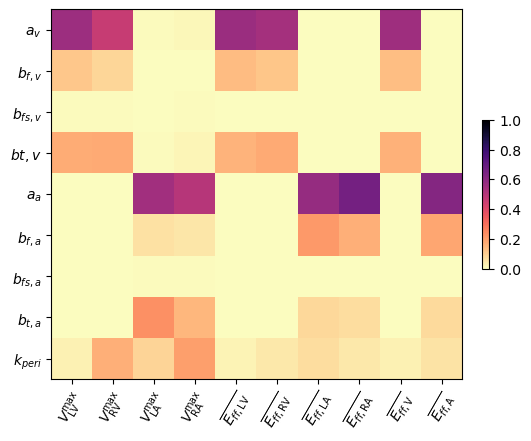

In [26]:
inputs = X_all.columns.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_first[0:28],cmap='magma_r',vmin=0,vmax=1)

ax.set_xticks(np.arange(len(outputs)),labels=outputs)
ax.set_yticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

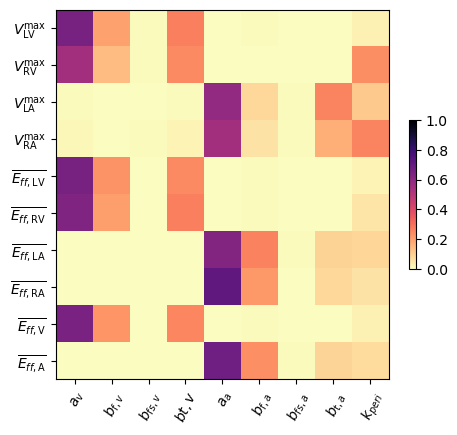

In [27]:
inputs = X_all.columns.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_total.T[0:28],cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=65, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

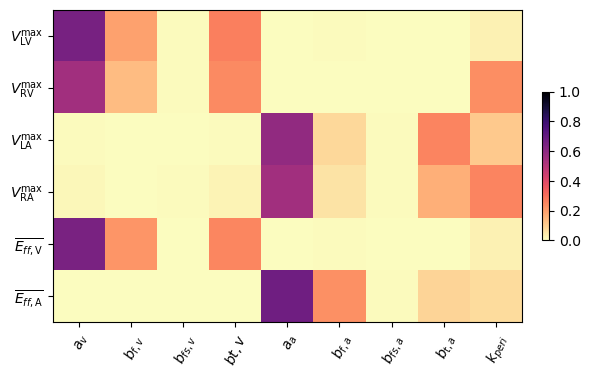

In [42]:
inputs = X_all.columns.tolist()
outputs = y_all.columns[[0,1,2,3,8,9]].tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_total.T[[0,1,2,3,8,9]],cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=65, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [28]:
y_all

,$V^{\mathrm{max}}_{\mathrm{LV}}$,$V^{\mathrm{max}}_{\mathrm{RV}}$,$V^{\mathrm{max}}_{\mathrm{LA}}$,$V^{\mathrm{max}}_{\mathrm{RA}}$,"$\overline{E_{ff,\mathrm{LV}}}$","$\overline{E_{ff,\mathrm{RV}}}$","$\overline{E_{ff,\mathrm{LA}}}$","$\overline{E_{ff,\mathrm{RA}}}$","$\overline{E_{ff,\mathrm{V}}}$","$\overline{E_{ff,\mathrm{A}}}$"
0,176.068,171.084,68.2983,87.2082,0.023290,0.018751,0.105532,0.070459,0.022349,0.082731
1,170.459,165.900,56.1189,79.2871,0.015556,0.012323,0.023607,0.014270,0.014881,0.017635
2,170.071,169.104,58.5605,82.3657,0.015797,0.014367,0.033045,0.019283,0.015516,0.024336
3,201.667,191.819,59.4689,82.9831,0.057794,0.046807,0.047235,0.030274,0.055443,0.036327
4,169.384,167.307,60.0413,82.8489,0.014711,0.012212,0.067935,0.037819,0.014183,0.048680
...,...,...,...,...,...,...,...,...,...,...
175,176.629,171.773,62.1838,84.7443,0.019615,0.016549,0.076106,0.054268,0.019031,0.061742
176,186.282,176.219,61.2773,81.9510,0.036178,0.028614,0.063980,0.041068,0.034666,0.048985
177,171.946,168.570,56.7536,79.7173,0.018136,0.015846,0.020815,0.011969,0.017695,0.015177
178,200.781,197.025,70.8535,91.5856,0.055808,0.049540,0.121958,0.072069,0.054477,0.090398


In [29]:
y_train

tensor([[1.7607e+02, 1.7108e+02, 6.8298e+01,  ..., 7.0459e-02, 2.2349e-02,
         8.2731e-02],
        [1.7046e+02, 1.6590e+02, 5.6119e+01,  ..., 1.4270e-02, 1.4881e-02,
         1.7635e-02],
        [1.7007e+02, 1.6910e+02, 5.8560e+01,  ..., 1.9283e-02, 1.5516e-02,
         2.4336e-02],
        ...,
        [1.7195e+02, 1.6857e+02, 5.6754e+01,  ..., 1.1969e-02, 1.7695e-02,
         1.5177e-02],
        [2.0078e+02, 1.9703e+02, 7.0853e+01,  ..., 7.2069e-02, 5.4477e-02,
         9.0398e-02],
        [1.6537e+02, 1.6301e+02, 5.8184e+01,  ..., 2.4207e-02, 9.4279e-03,
         2.9606e-02]], dtype=torch.float64)

In [30]:
y_all.copy().drop(y_all.index[i]).values

array([[1.76068e+02, 1.71084e+02, 6.82983e+01, ..., 7.04586e-02,
        2.23493e-02, 8.27313e-02],
       [1.70459e+02, 1.65900e+02, 5.61189e+01, ..., 1.42702e-02,
        1.48809e-02, 1.76345e-02],
       [1.70071e+02, 1.69104e+02, 5.85605e+01, ..., 1.92825e-02,
        1.55160e-02, 2.43364e-02],
       ...,
       [1.71946e+02, 1.68570e+02, 5.67536e+01, ..., 1.19691e-02,
        1.76954e-02, 1.51774e-02],
       [2.00781e+02, 1.97025e+02, 7.08535e+01, ..., 7.20689e-02,
        5.44770e-02, 9.03980e-02],
       [1.65372e+02, 1.63010e+02, 5.81845e+01, ..., 2.42075e-02,
        9.42788e-03, 2.96062e-02]])

In [31]:
nsamp=100
MSE = np.zeros((y_all.shape[0],y_all.shape[1]))

for i in range(y_all.shape[0]):
    y_train = torch.tensor(y_all.copy().drop(y_all.index[i]).values)
    X_train = torch.tensor(input_masked.copy().drop(y_all.index[i]).values)
    
    y_test = torch.tensor(y_all.loc[[y_all.index[i]]].values)
    X_test = torch.tensor(input_masked.loc[[y_all.index[i]]].values)
    
    
    
    emulator = GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=500)
    MSE[i,:] = emulator.MSE(X_test,y_test).detach().numpy()

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8


KeyboardInterrupt: 

In [ ]:
1-MSE.mean(axis=0)/np.var(y_all,axis=0)

In [ ]:
MSE.shape

In [ ]:
MSE[0].shape

In [ ]:
np.var(y_all,axis=0).shape

In [ ]:
R2=np.zeros((18,28))
for i in range(18):
    R2[i]=(1-MSE[i]/np.var(y_all,axis=0))

In [ ]:
fig, ax = plt.subplots()


ax.scatter(y_labels.values.squeeze(),np.array(1-MSE.mean(axis=0)/np.var(y_all,axis=0)))
plt.errorbar(y_labels.values.squeeze(),np.array(1-MSE.mean(axis=0)/np.var(y_all,axis=0)),fmt='o',yerr=R2.std(axis=0))
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

In [ ]:
y_calibration = y_all.loc[:,['V_TAT','A_TAT','LVpMax','LVedv','LVesv']]

In [ ]:
y_calibration2 = pd.DataFrame({'LV_EF':(y_all.loc[:,'LVedv']-y_all.loc[:,'LVesv'])/y_all.loc[:,'LVedv']})

In [ ]:
y_calibration2=y_calibration.join(y_calibration2)

In [ ]:
MSE = np.zeros((y_calibration.shape[0],y_calibration.shape[1]))

for i in range(y_calibration.shape[0]):
    y_train = torch.tensor(y_calibration.copy().drop(y_calibration.index[i]).values)
    X_train = torch.tensor(input_masked.copy().drop(y_calibration.index[i]).values)
    
    y_test = torch.tensor(y_calibration.loc[[y_calibration.index[i]]].values)
    X_test = torch.tensor(input_masked.loc[[y_calibration.index[i]]].values)
    print(y_test)
    emulator = GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=500)
    MSE[i,:] = emulator.MSE(X_test,y_test).detach().numpy()

In [ ]:
R2=np.zeros((18,5))
for i in range(18):
    R2[i]=(1-MSE[i]/np.var(y_calibration,axis=0))

In [ ]:
R2.std(axis=0)

In [ ]:
plt.plot(np.array(1-MSE.mean(axis=0)/np.var(y_calibration,axis=0)),'o')

In [ ]:
y_calibration.columns.values.tolist()

In [ ]:
fig, ax = plt.subplots()


ax.scatter(y_calibration.columns.values.tolist(),np.array(1-MSE.mean(axis=0)/np.var(y_calibration,axis=0)))
plt.errorbar(y_calibration.columns.values.tolist(),np.array(1-MSE.mean(axis=0)/np.var(y_calibration,axis=0)),fmt='o',yerr=R2.std(axis=0))
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

In [ ]:
X_train = torch.tensor(input_masked.values)

In [ ]:
y_train=torch.tensor(y_calibration.values)

In [ ]:
X_train

In [ ]:
emulator=GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=500)

In [ ]:
nDim = X_train.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([torch.min(X_train[:,i]).detach().numpy(),torch.max(X_train[:,i]).detach().numpy()])
    print(boundsMaxMin[i])

In [ ]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = torch.tensor(param_values)
#data1.columns = X_train.columns

Ymean=emulator.predict(data1)

In [ ]:
Si = []
nMod = y_train.shape[1]
nDim = X_train.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean[:,i].detach().numpy(), print_to_console=True,calc_second_order=True))

In [ ]:
Si_first=np.zeros((nDim,nMod))
Si_total=np.zeros((nDim,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]


In [ ]:
inputs = x_labels.values.tolist()
outputs = y_calibration.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_first.T[0:10],cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [ ]:
inputs = x_labels.values.tolist()
outputs = y_calibration.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_total.T,cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [ ]:
emulator.predict(data1).detach().numpy()[:,4]

In [ ]:
fig = plt.figure()
ax=fig.add_subplot(projection='3d')
ax.scatter(data1[:,4],data1[:,6],emulator.predict(data1).detach().numpy()[:,3])
plt.ylabel('a_ventricles')
plt.xlabel('EDP_lv')

In [ ]:
Si[i].to_df()

In [ ]:
y_calibration

In [ ]:
y_calibration = y_all.loc[:,['V_TAT','LVpMax']]

In [ ]:
y_calibration2 = pd.DataFrame({'LV_EF':(y_all.loc[:,'LVedv']-y_all.loc[:,'LVesv'])/y_all.loc[:,'LVedv']})

In [ ]:
y_calibration=torch.tensor(y_calibration.join(y_calibration2).values)

In [ ]:
emulator=GPE.ensemble(torch.tensor(input_masked.values),y_calibration,mean_func="linear",training_iter=500)

In [ ]:
input_masked

In [ ]:
boundsMaxMin

In [ ]:
boundsMaxMin

In [ ]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2

In [ ]:
import emcee
ndim = nDim
nwalkers = 18
p0 = np.random.multivariate_normal(centre, 0.000000001*np.identity(ndim), size=(nwalkers))
y_val = torch.tensor([100,157,0.8])

In [ ]:
boundsMaxMin

In [ ]:
np.array(boundsMaxMin)[:,0]*2

In [ ]:
p0[0]

In [ ]:
def log_prior(theta):
    
    #if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        
    if (np.array(boundsMaxMin)[:,0]*0.5<theta).all() and (theta<np.array(boundsMaxMin)[:,1]*2).all():
        return 0.0
    return -np.inf

In [ ]:
def log_likelihood(x,emulator,y_val):
    x=torch.tensor(x)[None]
    ll =np.sum((emulator.ensemble_log_likelihood_obs_error(x,y_val[None,:],0)).detach().numpy())
    return ll

In [ ]:
def log_prob(theta, emulator,y_val):
    
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + log_likelihood(theta,emulator, y_val)

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val])

In [ ]:
p0[i].shape

In [ ]:
torch.tensor(p0[0]).shape

In [ ]:
emulator.predict(torch.tensor(p0)).shape

In [ ]:
for i in range(16):
    print(log_prob(p0[i],emulator,y_val))

In [ ]:
sampler.run_mcmc(p0, 40000)

In [ ]:
flat_samples = sampler.get_chain(discard=20000, thin=10, flat=True)
print(flat_samples.shape)

In [ ]:
import corner

fig = corner.corner(
    flat_samples, labels=x_labels.values, label_kwargs=dict(fontsize=18)
);

In [ ]:
samp = pd.DataFrame(flat_samples).sample(50)

In [ ]:
samp.to_csv("MCMC_samples_scenario_6_80_2timesUpper.dat", sep = " ",index=False,header=None)

In [ ]:
flat_samples.mean(axis=0)

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [ ]:
x_out = torch.tensor(flat_samples.mean(axis=0).T)


In [ ]:
y_calibration

In [ ]:
x_out.shape

In [ ]:
emulator.predict(x_out[None,:])

In [ ]:
torch.tensor(flat_samples.T).shape

In [ ]:
plt.hist(emulator.predict(torch.tensor(flat_samples))[:,3].detach().numpy())

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = flat_samples
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [ ]:
working = model.predict(flat_samples)

In [ ]:
plt.plot(working,'o')

# Calibration with fixed inputs

In [ ]:
new_input=input_masked.copy()
new_input=new_input.drop(['CV_atria','a_atria','a_ventricles'],axis=1)

In [ ]:
emulator = GPE.ensemble(new_input,y_calibration,mean_func="linear",training_iter=500)

In [ ]:
nDim = new_input.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(new_input.iloc[:,i]),np.max(new_input.iloc[:,i])])
    print(boundsMaxMin[i])

In [ ]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2

In [ ]:
nDim

In [ ]:
import emcee
ndim = nDim
nwalkers = 16
p0 = np.random.multivariate_normal(centre, 0.001*np.identity(ndim), size=(nwalkers))
y_val = [100,157,111,0.5]

In [ ]:
x_labels.values.squeeze().tolist()

In [ ]:
new_input.columns

In [ ]:
def log_likelihood(x,emulator,y_val):
    x=pd.DataFrame(x).T
    x.columns = new_input.columns.values.squeeze().tolist()
    y_val = pd.DataFrame(y_val).T
    y_val.columns = y_calibration.columns.values.squeeze().tolist()
    ll =np.sum(emulator.ensemble_log_likelihood(x,y_val))
    return ll

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val])

In [ ]:
sampler.run_mcmc(p0, 30000)

In [ ]:
flat_samples = sampler.get_chain(discard=6000, thin=10, flat=True)
print(flat_samples.shape)

In [ ]:
import corner

fig = corner.corner(
    flat_samples, labels=x_labels.values, label_kwargs=dict(fontsize=18)
);

In [ ]:
samp = pd.DataFrame(flat_samples).sample(50)

In [ ]:
samp.to_csv("MCMC_samples_scenario_5_90.dat", sep = " ",index=False,header=None)

In [ ]:
flat_samples.mean(axis=0)

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [ ]:
x_out = pd.DataFrame(flat_samples.mean(axis=0)).T
x_out.columns = new_input.columns.values.squeeze()

In [ ]:
y_calibration.columns

In [ ]:
emulator.predict(x_out)

In [ ]:
plt.hist(emulator.predict(pd.DataFrame(flat_samples,columns=input_masked.columns))[:,3].detach().numpy())

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = flat_samples
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

# Multi-Output GP

In [ ]:
import mogptk

In [ ]:
y_calibration

In [ ]:
# split original dataset in training, validation and testing sets
X=input_masked
y=y_calibration
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=seed
)

In [ ]:
MOData = pd.concat((X_train,y_train),axis=1)


In [ ]:
MOData

In [ ]:
y_calibration2.columns.values.tolist()

In [ ]:
dataset = mogptk.LoadDataFrame(MOData,x_col=input_masked.columns.values.tolist(),y_col=y_calibration2.columns.values.tolist())
dataset.transform(mogptk.TransformNormalize)
dataset

In [ ]:
dataset.get_test_data()

In [ ]:
# create model, uncomment for different kernels 
#model = mogptk.MOSM(dataset, Q=2)
#model = mogptk.CSM(dataset, Q=4)
#model = mogptk.SM_LMC(dataset, Q=4)
model = mogptk.CONV(dataset, Q=4)

# initialize parameters of kernel using LombScargle
model.init_parameters(method='LS', iters=500)

In [ ]:
model.train(method='Adam', lr=0.1, iters=7000, plot=True, error='MSE', verbose=True);

In [ ]:
model.predict(X_test.values)[1]

In [ ]:
np.mean((y_test.values.T-model.predict(X_test.values)[1])**2,axis=1)/X_test.shape[0]

In [ ]:
emulator = GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=1000)

In [ ]:
emulator.MSE(X_test,y_test)

In [ ]:
model.plot_correlation()

In [ ]:
model.print_parameters()

In [ ]:
params?

In [ ]:
params = []

for p in model.parameters():
    params.append(p)

In [ ]:
params

In [ ]:
plt.imshow([[0.0009756545815890106, 0.0, 0.0, 0.0, 27819.543719613113, 0.0, 0.0, 0.0], [1.7460115277182566, 0.0, 0.0, 119410.25481699423, 0.0, 0.0, 0.0, 0.0], [11.369120898808664, 115237.02973475368, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.6990749064961943, 0.0, 0.0, 74757.56112865475, 0.0, 0.0, 0.0, 0.0]])

In [ ]:
plt.imshow([[10.162908005474888, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [37.97208882285453, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [35.583222651507306, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [7.01360765548753, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

In [ ]:
# split original dataset in training, validation and testing sets
X=input_masked
y=y_all
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=seed
)

In [ ]:
MOData = pd.concat((X_train,y_train),axis=1)


In [ ]:
MOData

In [ ]:
y_calibration.columns.values.tolist()

In [ ]:
dataset = mogptk.LoadDataFrame(MOData,x_col=input_masked.columns.values.tolist(),y_col=y_all.columns.values.tolist())
dataset.transform(mogptk.TransformNormalize)
dataset

In [ ]:
dataset.get_test_data()

In [ ]:
# create model, uncomment for different kernels 
#model = mogptk.MOSM(dataset, Q=2)
#model = mogptk.CSM(dataset, Q=4)
#model = mogptk.SM_LMC(dataset, Q=4)
model = mogptk.CONV(dataset, Q=2)

# initialize parameters of kernel using LombScargle
model.init_parameters(method='LS', iters=500)

In [ ]:
model.train(method='SGD', lr=0.01, iters=3500, plot=True, error='MSE', verbose=True);

In [ ]:
model.train(method='SGD', lr=0.01, iters=500, plot=True, error='MSE', verbose=True);

In [ ]:
model.predict(X_test.values)[1]

In [ ]:
np.mean((y_test.values.T-model.predict(X_test.values)[1])**2,axis=1)/X_test.shape[0]

In [ ]:
model.plot_correlation()

In [ ]:
fig, ax = model.plot_correlation(figsize=(25, 25))

In [ ]:
start=time.time()
emulator = GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=500)

end = time.time()
print(end - start)

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
X_test

In [ ]:
import cigp_v10 as cig

In [ ]:
model = cig.cigp(torch.tensor(X_train.values),torch.tensor(y_train.values),normal_y_mode=1)

In [ ]:
import time
start = time.time()


model.train_adam(niteration=500)



In [ ]:
(torch.sum((model.forward(torch.tensor(X_test.values))[0]-torch.tensor(y_test.values))**2,axis=0))/y_test.values.shape[0]

In [ ]:
mogptMSE = np.array([9.10333333e-01, 1.33455636e-02, 8.78157403e-01, 6.69582124e-01,
       3.70024071e+02, 1.23460430e+02, 6.35753356e-01, 6.52791491e-04,
       3.76409392e-01, 5.31805275e-01, 1.71110574e+02, 5.49810697e+00,
       1.05649088e-01, 7.97417780e-02, 1.55348111e-01, 1.24083716e-02,
       5.45010526e-02, 5.65038223e-02, 1.02820944e-01, 1.11955787e-03,
       2.06413166e-02, 1.92173725e-02, 5.43121107e-02, 2.30204748e-02,
       1.96869906e-02, 1.69456459e-02, 1.63021757e+01, 1.57392304e+00])

In [ ]:
GPMSE = emulator.MSE(X_test,y_test).detach().numpy()
CIGMSE=((torch.sum((model.forward(torch.tensor(X_test.values))[0]-torch.tensor(y_test.values))**2,axis=0))/y_test.values.shape[0]).detach().numpy()

In [ ]:
fig, ax = plt.subplots()



im=plt.plot(1-GPMSE/np.var(y_test,axis=0),'o')
plt.plot(1-mogptMSE/np.var(y_test,axis=0),'o')
plt.plot(1-CIGMSE/np.var(y_test,axis=0),'o')
plt.legend(('GP','MOGPT','CIGP'))


plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

In [ ]:
np.mean((y_test.values.T-model.predict(X_test.values)[1])**2,axis=1)/X_test.shape[0]

In [ ]:
np.var(y_test,axis=0)

In [ ]:
y_all.iloc[:,[4]].max()

In [ ]:
y_all.iloc[:,[4]].min()

In [ ]:
y_all.iloc[:,[4]].std()